# Traffic and Airprox Correlations
> Author: A.Pilko@soton.ac.uk

2019 Air traffic data and 2000-2021 airprox data is used to investigate correlations in the datasets.

## Hypotheses:
- Airprox locations will have less ordered traffic flow, concretely the variance of traffic direction will positively correlate with airprox locations
- Airprox locations will positively correlate with traffic density
- Airprox locations will positively correlate with mean traffic flow speed
- Airprox locations will positively correlate with the variance of the flow speed


Import required libraries and pre-cleaned data

In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import traffic
import numpy as np
import pyproj
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import joblib as jl

from cartopy.crs import Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

%matplotlib notebook

In [2]:
airprox_gdf = gpd.GeoDataFrame(pd.read_pickle('../data/airprox_asp_2000_2021.pkl'))
# tfc_clean = traffic.core.Traffic.from_file('../data/cornwall_tfc_clean_30s_lt3000ft_2019_filt10_f16.pkl')
tfc_clean = traffic.core.Traffic.from_file('../data/southeng_tfc_clean_lt5000ft_2019.pkl.bz2')

In [3]:
tfc_clean.data.head()

,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,onground,spi,squawk,track,vertical_rate,flight_id,track_unwrapped
0,2019-01-01 06:27:30+00:00,False,3650.0,SAA234,4800.0,186.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.132446,False,False,4010,269.75,-1536.0,SAA234_000,269.75
1,2019-01-01 06:28:00+00:00,False,3650.0,SAA234,4800.0,185.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.143066,False,False,4010,270.00,-1536.0,SAA234_000,270.00
2,2019-01-01 06:28:30+00:00,False,3250.0,SAA234,3900.0,183.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.183838,False,False,4010,269.75,-1856.0,SAA234_000,269.75
3,2019-01-01 06:29:00+00:00,False,2524.0,SAA234,3176.0,174.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.223267,False,False,4010,270.00,-1472.0,SAA234_000,270.00
4,2019-01-01 06:29:30+00:00,False,1625.0,SAA234,2324.0,171.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.261475,False,False,4010,270.00,-896.0,SAA234_000,270.00


## Airspace

There isn't much point analysing the traffic patterns for controlled airspace where ATC are issuing instructions or aircraft are (usually) following standard routes (SIDs, STARs). The UK airspace is used to filter out the traffic state vectors that are located in controlled airspace. All the traffic that is only in uncontrolled airspace is then used for the actual analysis.

In [4]:
import requests

req = requests.get('https://storage.googleapis.com/29f98e10-a489-4c82-ae5e-489dbcd4912f/gb_asp.geojson')
with open('gb_asp.geojson', 'w') as f:
    f.write(req.text)

In [5]:
ASP_TYPES = {
    0: "Other",
    1: "Restricted",
    2: "Danger",
    3: "Prohibited",
    4: "Controlled Tower Region (CTR)",
    5: "Transponder Mandatory Zone (TMZ)",
    6: "Radio Mandatory Zone (RMZ)",
    7: "Terminal Maneuvering Area (TMA)",
    8: "Temporary Reserved Area (TRA)",
    9: "Temporary Segregated Area (TSA)",
    10: "Flight Information Region (FIR)",
    11: "Upper Flight Information Region (UIR)",
    12: "Air Defense Identification Zone (ADIZ)",
    13: "Airport Traffic Zone (ATZ)",
    14: "Military Airport Traffic Zone (MATZ)",
    15: "Airway",
    16: "Military Training Route (MTR)",
    17: "Alert Area",
    18: "Warning Area",
    19: "Protected Area",
    20: "Helicopter Traffic Zone (HTZ)",
    21: "Gliding Sector",
    22: "Transponder Setting (TRP)",
    23: "Traffic Information Zone (TIZ)",
    24: "Traffic Information Area (TIA)",
    25: "Military Training Area (MTA)",
    26: "Controlled Area (CTA)",
    27: "ACC Sector (ACC)",
    28: "Aerial Sporting Or Recreational Activity",
    29: "Low Altitude Overflight Restriction"
}

ASP_CLASS = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "Special Use Airspace (SUA)",
    8: "Unclassified"
}

ASP_ACTIVITIES = {
    0: "None - No specific activity (default)",
    1: "Parachuting Activity",
    2: "Aerobatics Activity",
    3: "Aeroclub And Arial Work Area",
    4: "Ultra Light Machine (ULM) Activity",
    5: "Hang Gliding/Paragliding"
}

ASP_ALT_UNIT = {
    0: "Meter",
    1: "Feet",
    6: "Flight Level",
}

ASP_ALT_DATUM = {
    0: "GND",
    1: "MSL",
    2: "STD",
}

In [6]:
asp_gdf = gpd.read_file('gb_asp.geojson')
asp_gdf = asp_gdf[(asp_gdf['approved'] == True) & (asp_gdf['onDemand'] == False) & (asp_gdf['onRequest'] == False) & (
        asp_gdf['byNotam'] == False) & (asp_gdf['specialAgreement'] == False)]
asp_gdf = asp_gdf.cx[
          tfc_clean.data.longitude.min():tfc_clean.data.longitude.max(),
          tfc_clean.data.latitude.min(): tfc_clean.data.latitude.max()
          ]
asp_upper_lims = pd.DataFrame(pd.json_normalize(asp_gdf.upperLimit))
asp_lower_lims = pd.DataFrame(pd.json_normalize(asp_gdf.lowerLimit))
asp_upper_lims.columns = ['upperLimit_value', 'upperLimit_unit', 'upperLimit_ref']
asp_lower_lims.columns = ['lowerLimit_value', 'lowerLimit_unit', 'lowerLimit_ref']
asp_lim_df = pd.concat([asp_lower_lims, asp_upper_lims], axis=1)
asp_gdf = pd.concat([asp_gdf, asp_lim_df], axis=1)
asp_gdf = asp_gdf.drop(
    labels=['_id', 'approved', 'specialAgreement', 'onDemand', 'onRequest', 'byNotam', 'createdAt', 'createdBy',
            'updatedAt', 'updatedBy', 'upperLimit', 'lowerLimit'], axis=1)
for col in ['type', 'icaoClass', 'activity']:
    asp_gdf[col] = pd.Categorical(asp_gdf[col])
asp_gdf['type'] = asp_gdf['type'].cat.rename_categories(ASP_TYPES)
asp_gdf['icaoClass'] = asp_gdf['icaoClass'].cat.rename_categories(ASP_CLASS)
asp_gdf['activity'] = asp_gdf['activity'].cat.rename_categories(ASP_ACTIVITIES)

In [7]:
def alt_std(row):
    cr = row.copy()
    if cr['upperLimit_unit'] == 0:
        cr['upperLimit_value'] *= 3.28084
    elif cr['upperLimit_unit'] == 6:
        cr['upperLimit_value'] *= 100

    if cr['lowerLimit_unit'] == 0:
        cr['lwoerLimit_value'] *= 3.28084
    elif cr['lowerLimit_unit'] == 6:
        cr['lowerLimit_value'] *= 100

    return cr


asp_gdf = asp_gdf.apply(alt_std, axis=1).dropna()
asp_gdf = asp_gdf[asp_gdf['lowerLimit_value'] <= 5000]
asp_gdf = asp_gdf.drop(labels=['upperLimit_unit', 'upperLimit_ref', 'lowerLimit_unit', 'lowerLimit_ref'], axis=1)

asp_gdf

,name,type,icaoClass,activity,country,geometry,lowerLimit_value,upperLimit_value
7,BERRY HEAD CTA,Other,A,None - No specific activity (default),GB,"POLYGON ((-2.89306 51.25139, -2.99333 50.70444...",4500.0,10500.0
36,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.95883 51.37879, -2.95878 51.38819...",1500.0,2500.0
37,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.43722 51.47667, -2.43722 51.47667...",2500.0,3500.0
39,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.51250 51.30722, -2.51250 51.30722...",2500.0,5500.0
40,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,"POLYGON ((-2.35111 51.47972, -2.35111 51.47972...",3500.0,5500.0
...,...,...,...,...,...,...,...,...
259,SOUTHEND CTA 130.780,Other,D,None - No specific activity (default),GB,"POLYGON ((0.84056 51.75833, 0.91944 51.76417, ...",0.0,1500.0
260,SOUTHEND CTA 130.780,Other,D,None - No specific activity (default),GB,"POLYGON ((0.45583 51.46583, 0.53389 51.41278, ...",0.0,2013.0
261,SOUTHEND CTA 130.780,Other,D,None - No specific activity (default),GB,"POLYGON ((0.83333 51.47472, 0.94028 51.43194, ...",0.0,2013.0
262,SOUTHEND CTA 130.780,Other,D,None - No specific activity (default),GB,"POLYGON ((0.75389 51.75167, 0.83472 51.78778, ...",0.0,2013.0


In [8]:
tfc_gdf = gpd.GeoDataFrame(tfc_clean.data,
                           geometry=gpd.points_from_xy(tfc_clean.data['longitude'], tfc_clean.data['latitude'],
                                                       tfc_clean.data['altitude']), crs='epsg:4326')

Since shapely only supports 2D geometries, we need to get creative to filter based on 3D airspace volumes. We iterate airspaces and select all traffic that is between the floor and ceiling of that airspace. A 2D point-in-polygon test is then run as usual.

This takes a decent chunk of time...

In [41]:
def tfc_within(lim_asp):
    lim_tfc = tfc_gdf[
        (tfc_gdf['altitude'] >= lim_asp['lowerLimit_value']) & (tfc_gdf['altitude'] <= lim_asp['upperLimit_value'])]
    return lim_tfc.sjoin(gpd.GeoDataFrame(lim_asp.to_frame().T).set_crs(asp_gdf.crs), predicate='within')

joined_dfs = jl.Parallel(n_jobs=-1, verbose=10)(jl.delayed(tfc_within)(lim_asp) for _, lim_asp in asp_gdf.iterrows())


con_asp_tfc_gdf = pd.concat(joined_dfs, axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
C:\ANACON~1\envs\sandbox\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 77.3min
[Parallel(n_jobs=-1)]: Done  44 out of  75 | elapsed: 113.3min remaining: 79.8min
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed: 134.2min remaining: 59.4min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 160.0min remaining: 40.0min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 180.8min remaining: 18.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 201.2min finished


In [42]:
con_asp_tfc_gdf.to_pickle('../data/southeng_con_asp_tfc_2019.pkl.bz2', compression='bz2')
print(con_asp_tfc_gdf.shape)
con_asp_tfc_gdf.head()

(1758547, 26)


,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,...,track_unwrapped,geometry,index_right,name,type,icaoClass,activity,country,lowerLimit_value,upperLimit_value
5141508,2019-04-23 22:02:00+00:00,0.0,4924.0,EZY75FG,4648.0,212.0,2019-04-23 22:00:00+00:00,400fe0,51.250,-2.898438,...,81.5625,POINT Z (-2.89844 51.25000 4924.00000),7,BERRY HEAD CTA,Other,A,None - No specific activity (default),GB,4500.0,10500.0
5141509,2019-04-23 22:02:30+00:00,0.0,4924.0,EZY75FG,4648.0,212.0,2019-04-23 22:00:00+00:00,400fe0,51.250,-2.894531,...,81.5625,POINT Z (-2.89453 51.25000 4924.00000),7,BERRY HEAD CTA,Other,A,None - No specific activity (default),GB,4500.0,10500.0
17537804,2019-12-18 16:47:30+00:00,0.0,4824.0,EZY35TU,4776.0,222.0,2019-12-18 16:00:00+00:00,40666a,51.250,-2.898438,...,72.3125,POINT Z (-2.89844 51.25000 4824.00000),7,BERRY HEAD CTA,Other,A,None - No specific activity (default),GB,4500.0,10500.0
8617,2019-01-01 21:36:00+00:00,False,1600.0,EZY78CB,2576.0,167.0,2019-01-01 21:00:00+00:00,400e59,51.375,-2.900391,...,87.2500,POINT Z (-2.90039 51.37500 1600.00000),36,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,1500.0,2500.0
8618,2019-01-01 21:36:30+00:00,False,1600.0,EZY78CB,2576.0,167.0,2019-01-01 21:00:00+00:00,400e59,51.375,-2.896484,...,87.2500,POINT Z (-2.89648 51.37500 1600.00000),36,BRISTOL CTA 125.650,Other,D,None - No specific activity (default),GB,1500.0,2500.0


In [47]:
unc_asp_tfc_gdf = pd.merge(tfc_gdf, con_asp_tfc_gdf, how="outer", indicator=True
                            ).query('_merge=="left_only"').drop(labels=['_merge'], axis=1)
unc_asp_tfc_gdf

,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,...,track_unwrapped,geometry,index_right,name,type,icaoClass,activity,country,lowerLimit_value,upperLimit_value
0,2019-01-01 06:27:30+00:00,False,3650.0,SAA234,4800.0,186.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.132446,...,269.7500,POINT Z (-0.13245 51.46875 3650.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 06:28:00+00:00,False,3650.0,SAA234,4800.0,185.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.143066,...,270.0000,POINT Z (-0.14307 51.46875 3650.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 06:28:30+00:00,False,3250.0,SAA234,3900.0,183.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.183838,...,269.7500,POINT Z (-0.18384 51.46875 3250.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 06:29:00+00:00,False,2524.0,SAA234,3176.0,174.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.223267,...,270.0000,POINT Z (-0.22327 51.46875 2524.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 06:29:30+00:00,False,1625.0,SAA234,2324.0,171.0,2019-01-01 06:00:00+00:00,00b1f9,51.46875,-0.261475,...,270.0000,POINT Z (-0.26147 51.46875 1625.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18251609,2019-12-31 12:16:00+00:00,False,1025.0,TAM8084,1550.0,133.0,2019-12-31 12:00:00+00:00,e48baa,51.46875,-0.601074,...,89.5625,POINT Z (-0.60107 51.46875 1025.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18251610,2019-12-31 12:16:30+00:00,False,650.0,TAM8084,1175.0,134.0,2019-12-31 12:00:00+00:00,e48baa,51.46875,-0.571289,...,89.5625,POINT Z (-0.57129 51.46875 650.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18251611,2019-12-31 12:17:00+00:00,False,300.0,TAM8084,800.0,136.0,2019-12-31 12:00:00+00:00,e48baa,51.46875,-0.541504,...,89.5625,POINT Z (-0.54150 51.46875 300.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18251612,2019-12-31 12:17:30+00:00,False,-75.0,TAM8084,475.0,138.0,2019-12-31 12:00:00+00:00,e48baa,51.46875,-0.511719,...,89.5625,POINT Z (-0.51172 51.46875 -75.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
unc_asp_tfc_gdf.to_pickle('../data/southeng_unc_asp_tfc_2019.pkl.bz2', compression='bz2')

In [53]:
unc_asp_tfc_gdf['type'] = 0
unc_asp_tfc_gdf['icaoClass'] = 6
unc_asp_tfc_gdf['name'] = 'UNCONTROLLED AIRSPACE'

unc_asp_tfc_gdf = unc_asp_tfc_gdf.drop(labels=['index_right', 'country', 'lowerLimit_value', 'upperLimit_value', 'activity'], axis=1)

In [56]:
unc_asp_tfc = traffic.core.Traffic(unc_asp_tfc_gdf)

Aggregate traffic data by projected XY and collect statistics for each cell.

In [57]:
res = 6000
tfc_agg = unc_asp_tfc.compute_xy('epsg:3857').assign(
    x=lambda elt: (elt.x // res) * res,
    y=lambda elt: (elt.y // res) * res,
).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.nanmean),
                          altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.nanmean),
                          track_std=pd.NamedAgg('track', np.std),
                          groundspeed_mean=pd.NamedAgg('groundspeed', np.nanmean),
                          groundspeed_std=pd.NamedAgg('groundspeed', np.std),
                          flight_id_nunique=('flight_id', 'nunique'))

Only use cells with over 30 samples in order for the Central Limit Theorem to hold. This ensures the distributions we extract from these cells are valid approximations of a Gaussian distribution.

In [58]:
tfc_magg = tfc_agg[tfc_agg['flight_id_nunique'] > 30]
tfc_gdf = tfc_agg.reset_index()
tfc_mgdf = tfc_magg.reset_index()
tfc_magg.head(10)

altitude_mean  altitude_std  track_mean   track_std  \
x         y                                                                
-324000.0 6576000.0         3594.0   3506.182632     209.500   86.112454   
          6582000.0         3668.0   1825.755509     229.625   77.366043   
          6588000.0         4928.0   7685.334379     211.750   83.231229   
          6594000.0         2798.0   1105.006056     203.375   89.226760   
          6630000.0         2922.0    933.447609     193.750   73.647505   
          6636000.0         3304.0    945.482884     155.250   92.775086   
          6642000.0         3030.0    752.862360     193.875   80.948673   
          6648000.0         3374.0    685.717713     167.625   91.532972   
          6654000.0         2880.0   1153.615299     171.875   88.946083   
          6660000.0         2172.0   1082.559131     168.250  100.166305   

                     groundspeed_mean  groundspeed_std  flight_id_nunique  
x         y                                                                
-324000.0 6576000.0           155.500       102.517814                 43  
          6582000.0           158.375        57.134661                 53  
          6588000.0           137.750        53.941086                 54  
          6594000.0           136.500        80.755392                 38  
          6630000.0           143.625        44.795214                 44  
          6636000.0           148.500        55.562071                 43  
          6642000.0           137.750        31.547182                 60  
          6648000.0           147.875        31.659165                 64  
          6654000.0           135.750        42.727785                 57  
          6660000.0           137.000        38.228691                113

In [59]:
airprox_gdf

,AirproxID,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,Aircraft2_Category,Aircraft2_Type,Aircraft2_FlightRules,Combined_Rules,x,y,geometry,name,type,icaoClass
3081,2014131,52.616667,-1.033333,2.0,c,general_aviation,rotorcraft_-_helicopter,ROBINSON - R22,vfr,general_aviation,fixed_wing_-_aeroplane,PIPER - PA34,vfr,vfr,-115030.140486,6.912404e+06,POINT Z (-1.03333 52.61667 2.00000),LEICESTER ATZ 122.130,Airport Traffic Zone (ATZ),Special Use Airspace (SUA)
1118,2015219,53.016667,-0.483333,6.0,b,military,fixed_wing_-_aeroplane,GROB - G115,vfr,military,fixed_wing_-_aeroplane,GROB - G115,vfr,vfr,-53804.420550,6.986081e+06,POINT Z (-0.48333 53.01667 6.00000),CRANWELL ATZ 124.450,Airport Traffic Zone (ATZ),Special Use Airspace (SUA)
1118,2015219,53.016667,-0.483333,6.0,b,military,fixed_wing_-_aeroplane,GROB - G115,vfr,military,fixed_wing_-_aeroplane,GROB - G115,vfr,vfr,-53804.420550,6.986081e+06,POINT Z (-0.48333 53.01667 6.00000),BARKSTON/CRANWELL MATZ 124.450,Military Airport Traffic Zone (MATZ),G
1530,2007083,50.683333,-1.116667,10.0,c,general_aviation,civil_private_or_club,SCOUT A.H. MK I,vfr,suas,model_aircraft,MODEL AIRCRAFT,vfr,vfr,-124306.764719,6.565469e+06,POINT Z (-1.11667 50.68333 10.00000),BEMBRIDGE 123.255,Gliding Sector,Special Use Airspace (SUA)
919,2011013,51.016667,-2.633333,10.0,e,military,rotorcraft_-_helicopter,OTHER - Military (Lynx),vfr,military,fixed_wing_-_aeroplane,OTHER - Military (Hawk),vfr,vfr,-293141.325756,6.624242e+06,POINT Z (-2.63333 51.01667 10.00000),YEOVILTON ATZ 127.350,Airport Traffic Zone (ATZ),Special Use Airspace (SUA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,2021235,51.416667,-0.100000,1350.0,c,emergency_services,rotorcraft_-_helicopter,MBB - BK117 (EC145),vfr,general_aviation,rotorcraft_-_helicopter,AGUSTA - A109,vfr,vfr,-11131.949079,6.695331e+06,POINT Z (-0.10000 51.41667 1350.00000),UNCONTROLLED AIRSPACE,0,6
4588,2021236,52.933333,-4.550000,260.0,d,general_aviation,other_-_paraglider,OTHER (Paraglider),vfr,unknown_aircraft,fixed_wing_-_aeroplane,UNKNOWN,unknown,unknown-vfr,-506503.683109,6.970676e+06,POINT Z (-4.55000 52.93333 260.00000),UNCONTROLLED AIRSPACE,0,6
4593,2021242,50.933333,-2.883333,14900.0,e,emergency_services,fixed_wing_-_aeroplane,BAE - AVRO146RJ - 100 - 70,vfr,military,fixed_wing_-_aeroplane,OTHER - Military (Hawk T1),vfr,vfr,-320971.198454,6.609510e+06,POINT Z (-2.88333 50.93333 14900.00000),UNCONTROLLED AIRSPACE,0,6
4595,2021245,53.666667,-0.533333,7400.0,e,civil_commercial,fixed_wing_-_aeroplane,CESSNA - 404,vfr,military,fixed_wing_-_aeroplane,OTHER - Military (E3),unknown,unknown-vfr,-59370.395090,7.107278e+06,POINT Z (-0.53333 53.66667 7400.00000),UNCONTROLLED AIRSPACE,0,6


In [60]:
x_idx = np.array(tfc_agg.index.levels[0])
y_idx = np.array(tfc_agg.index.levels[1])

In [61]:
airprox_gdf = airprox_gdf[
    (airprox_gdf.Latitude >= tfc_clean.data.latitude.min()) &
    (airprox_gdf.Latitude <= tfc_clean.data.latitude.max()) &
    (airprox_gdf.Longitude >= tfc_clean.data.longitude.min()) &
    (airprox_gdf.Longitude <= tfc_clean.data.longitude.max()) &
    ((airprox_gdf.icaoClass == 6) | (airprox_gdf.icaoClass == 'G') | (
            airprox_gdf.type == 'Radio Mandatory Zone (RMZ)') | (airprox_gdf.type == 'Gliding Sector'))
    ]

In [62]:
transformer = pyproj.Transformer.from_proj(pyproj.Proj("epsg:4326"), pyproj.Proj("epsg:3857"), always_xy=True)
x, y = transformer.transform(
    airprox_gdf.Longitude.values,
    airprox_gdf.Latitude.values,
)
airprox_gdf = airprox_gdf.assign(x=x, y=y)

Match up the locations of airproxes with the traffic stats in that cell

In [63]:
tfc_grid = np.array(tfc_magg.reset_index()[['x', 'y']])
airprox_locs = np.array(airprox_gdf[['x', 'y']])

In [64]:
tfc_idxs = cdist(tfc_grid, airprox_locs).argmin(axis=0)

In [65]:
tfc_cells = tfc_magg.iloc[tfc_idxs].reset_index()
airproxes_with_tfc = pd.concat([airprox_gdf.reset_index(), tfc_cells], axis=1)
airproxes_with_tfc = airproxes_with_tfc.drop(labels=['index', 'x', 'y'], axis=1)
airproxes_with_tfc

,AirproxID,Latitude,Longitude,Altitude,Risk,Aircraft1_Classification,Aircraft1_Category,Aircraft1_Type,Aircraft1_FlightRules,Aircraft2_Classification,...,name,type,icaoClass,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique
0,2011013,51.016667,-2.633333,10.0,e,military,rotorcraft_-_helicopter,OTHER - Military (Lynx),vfr,military,...,YEOVILTON MATZ 127.350,Military Airport Traffic Zone (MATZ),G,2494.0,1294.884655,199.125,97.156947,132.875,52.093896,98
1,2015181,50.850000,0.850000,74.0,e,commercial_air_transport,fixed_wing_-_aeroplane,ATR - ATR42,ifr,general_aviation,...,LYDD ILS,Other,G,2110.0,1546.198173,204.250,98.420319,154.375,88.866804,89
2,2006080,51.133333,-1.766667,100.0,c,military,military_fixed_wing,"GROB 115, TUTOR",vfr,military,...,BOSCOMBE DOWN/MIDDLE WALLOP MATZ 126.700,Military Airport Traffic Zone (MATZ),G,NaN,NaN,132.750,96.703523,123.625,47.263535,356
3,2021015,51.200000,-1.833333,100.0,c,ua/other,rpas,OTHER - Military (RPAS),vfr,military,...,BOSCOMBE DOWN/MIDDLE WALLOP MATZ 126.700,Military Airport Traffic Zone (MATZ),G,2912.0,3126.779151,125.750,102.288036,150.625,58.123832,151
4,2006080,51.133333,-1.766667,100.0,c,military,military_fixed_wing,"GROB 115, TUTOR",vfr,military,...,D120 BOSCOMBE DOWN (NOTAM),Other,G,NaN,NaN,132.750,96.703523,123.625,47.263535,356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,2021230,51.500000,-1.633333,2300.0,c,general_aviation,fixed_wing_-_aeroplane,PIPER - PA28,vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,2204.0,1031.939460,186.125,93.803343,103.500,45.657638,676
830,2021233,50.966667,-0.900000,900.0,c,military,rotorcraft_-_helicopter,OTHER - Military (Chinook),vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,3266.0,2113.550675,178.250,96.492855,180.500,80.440935,752
831,2021235,51.416667,-0.100000,1350.0,c,emergency_services,rotorcraft_-_helicopter,MBB - BK117 (EC145),vfr,general_aviation,...,UNCONTROLLED AIRSPACE,0,6,4160.0,979.622266,138.125,137.838237,201.000,80.542204,6541
832,2021242,50.933333,-2.883333,14900.0,e,emergency_services,fixed_wing_-_aeroplane,BAE - AVRO146RJ - 100 - 70,vfr,military,...,UNCONTROLLED AIRSPACE,0,6,3220.0,1377.081257,185.625,88.581728,168.125,84.879638,32


In [66]:
non_airprox_tfc = pd.merge(tfc_magg.reset_index(), tfc_cells.reset_index(), how="outer", indicator=True
                           ).query('_merge=="left_only"')
non_airprox_tfc

,x,y,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique,index,_merge
0,-324000.0,6576000.0,3594.0,3506.182632,209.500,86.112454,155.500,102.517814,43,NaN,left_only
1,-324000.0,6582000.0,3668.0,1825.755509,229.625,77.366043,158.375,57.134661,53,NaN,left_only
2,-324000.0,6588000.0,4928.0,7685.334379,211.750,83.231229,137.750,53.941086,54,NaN,left_only
3,-324000.0,6594000.0,2798.0,1105.006056,203.375,89.226760,136.500,80.755392,38,NaN,left_only
4,-324000.0,6630000.0,2922.0,933.447609,193.750,73.647505,143.625,44.795214,44,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
3533,162000.0,6702000.0,1559.0,2806.568711,134.125,90.577209,129.500,116.070682,65,NaN,left_only
3534,162000.0,6732000.0,4108.0,4623.609908,157.375,107.001480,203.875,90.854634,31,NaN,left_only
3535,162000.0,6738000.0,4752.0,5689.021220,225.250,72.729452,225.750,76.834614,89,NaN,left_only
3536,162000.0,6744000.0,4444.0,2262.610961,223.000,62.051831,228.750,51.186648,64,NaN,left_only


Sanity check the data at this point by plotting

In [67]:
airproxes_with_tfc.explore('altitude_mean', cmap='inferno')

C:\ANACON~1\envs\sandbox\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Examine the spatial coverage of the data. this is the area within which we can apply CLT and extract valid distributions

<IPython.core.display.Javascript object>


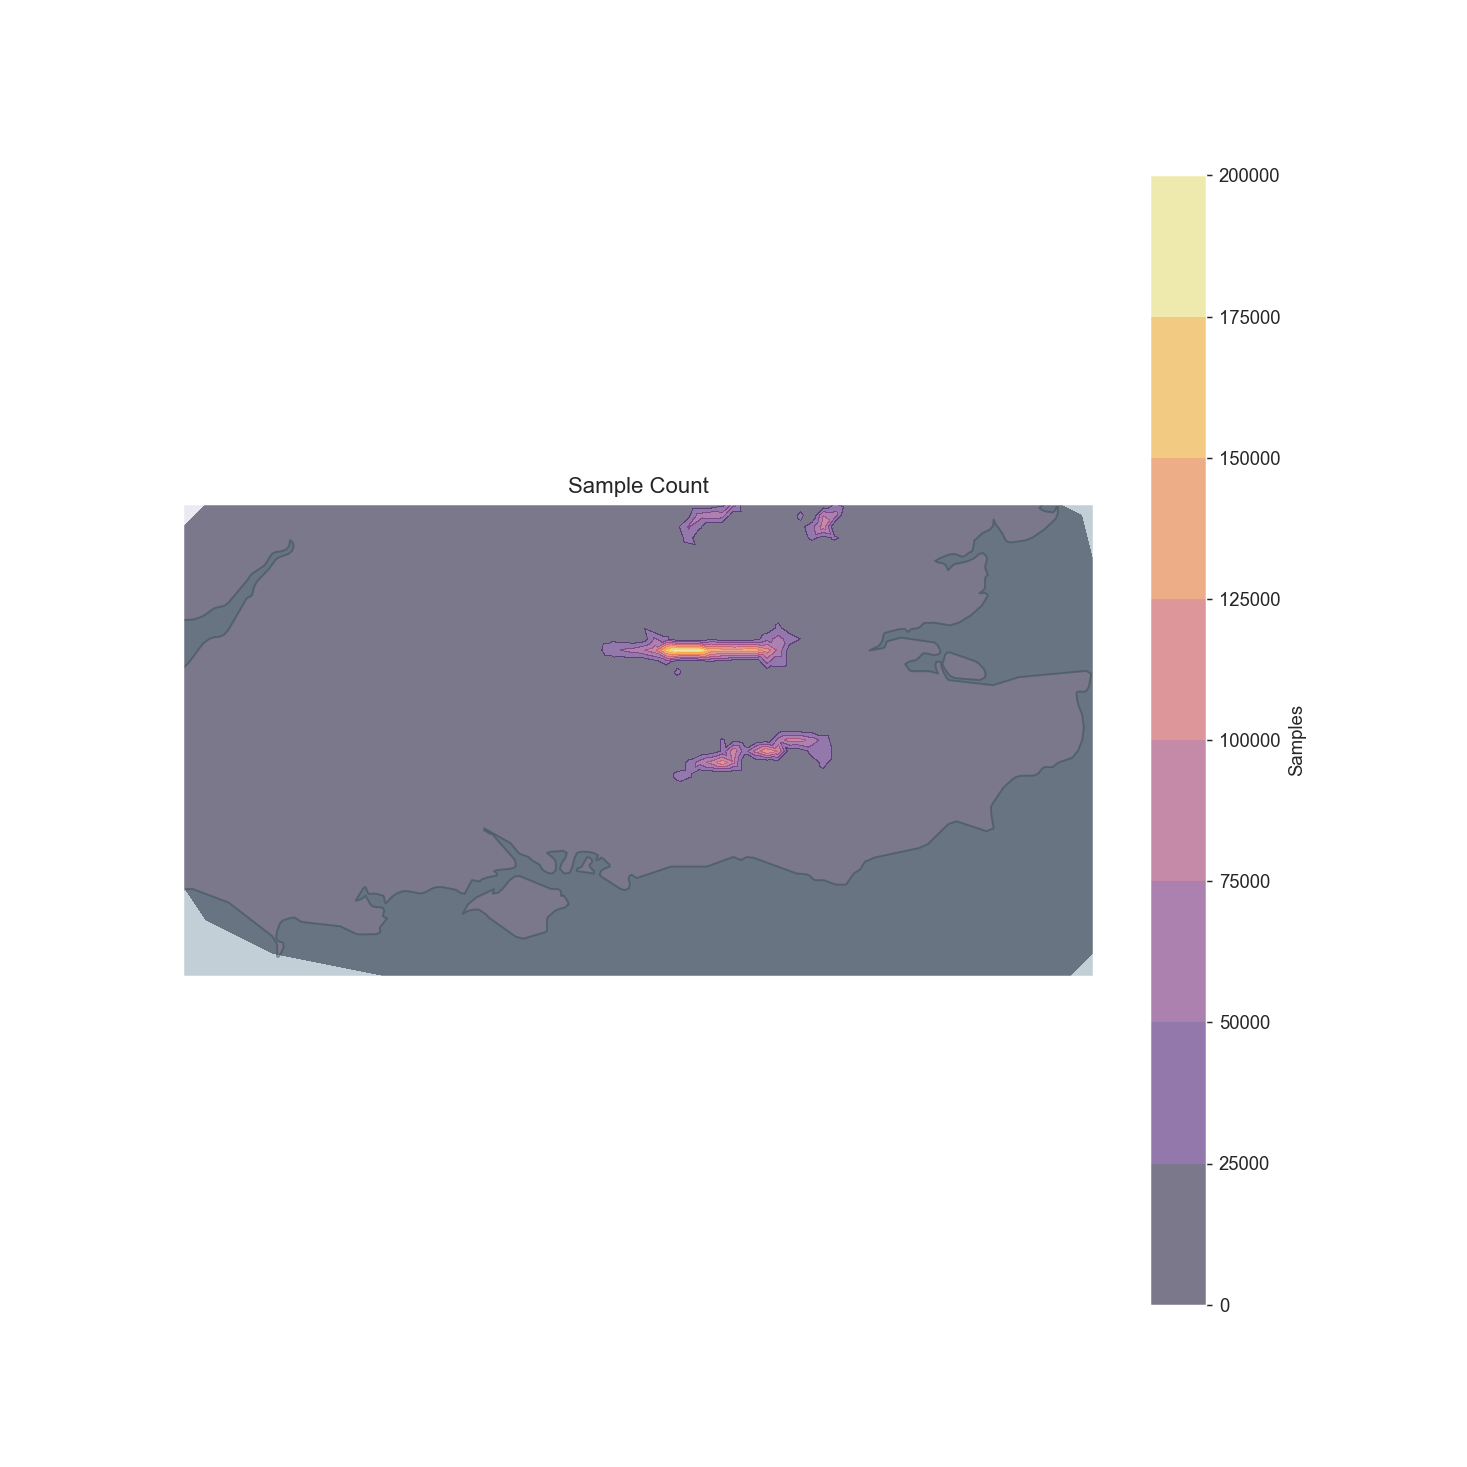

C:\Users\Aliak\AppData\Local\Temp\ipykernel_9976\1990523874.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(flow)


In [99]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['x'],
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['y'],
    tfc_gdf[tfc_gdf['flight_id_nunique'] > 30]['flight_id_nunique'],
    alpha=0.5,
    cmap='inferno')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Sample Count')
cb = fig.colorbar(flow)
cb.set_label('Samples')
# ax.legend([aps], ['Airprox'])

Plot a correlation matrix between all variables using the Pearson Correlation Coefficient

<IPython.core.display.Javascript object>


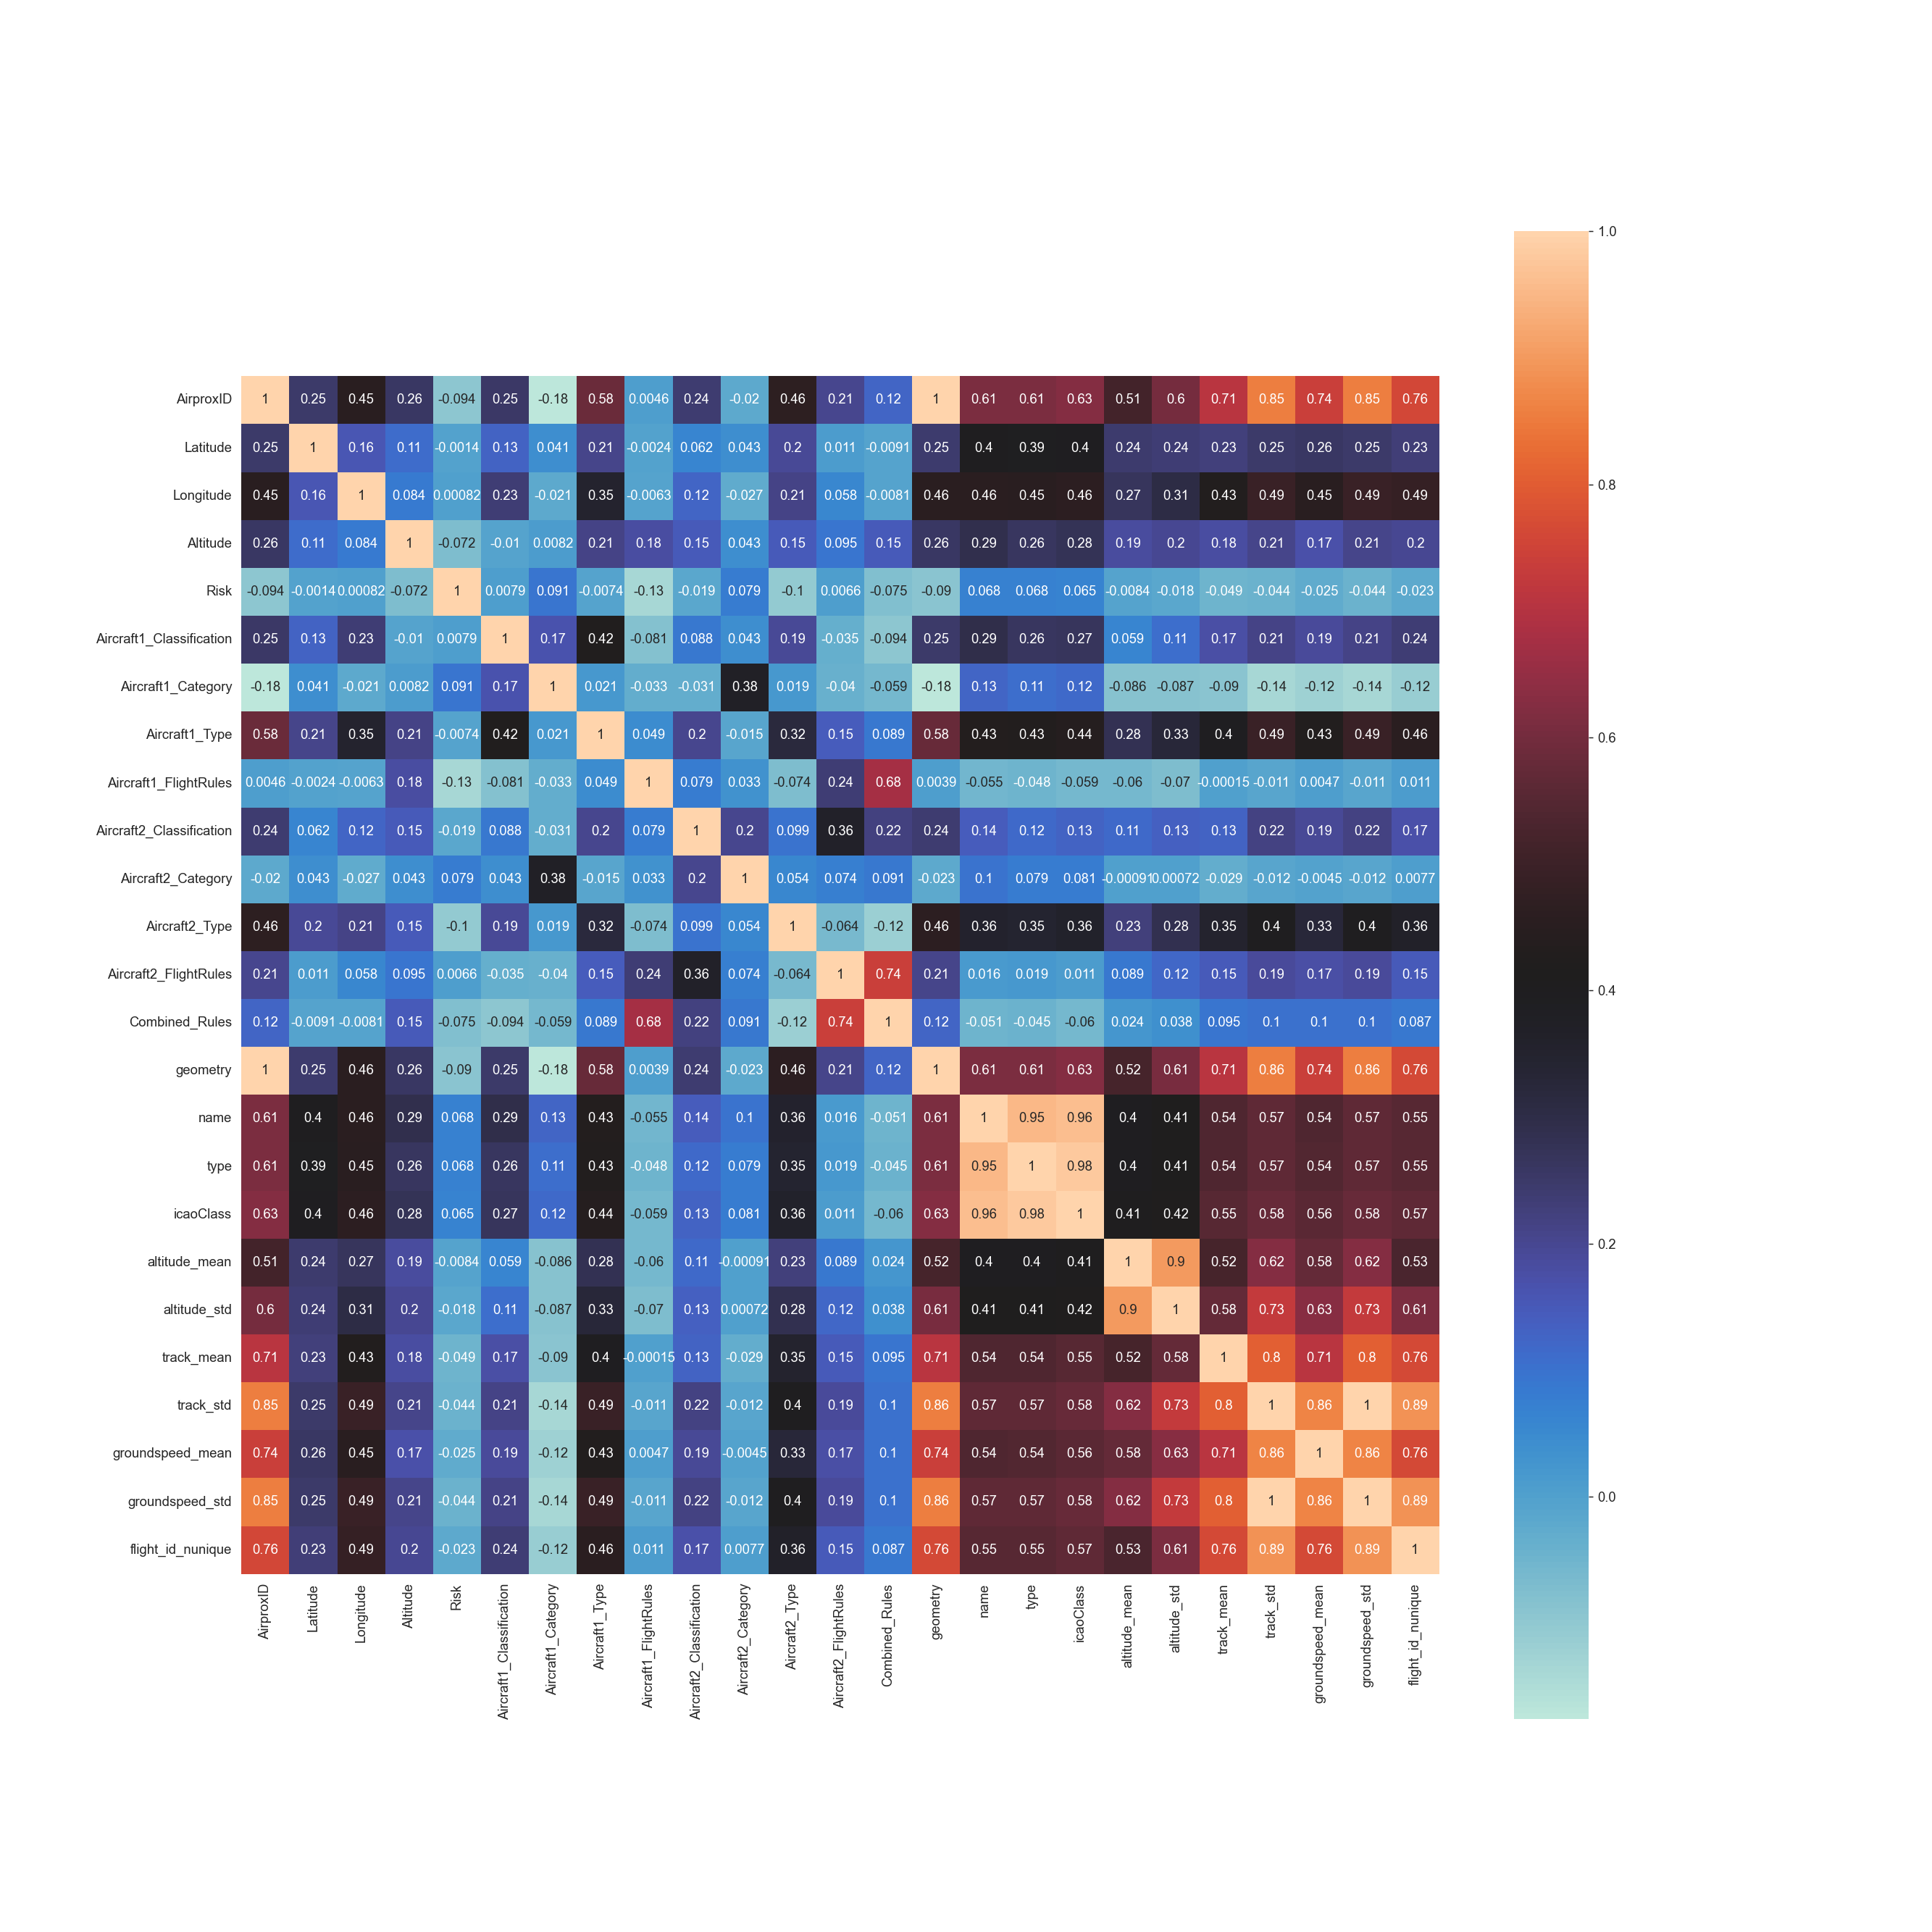

In [101]:
# corr = airproxes_with_tfc.corr(method='spearman')
corr = airproxes_with_tfc.apply(lambda x: pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, square=True, cmap=sns.color_palette('icefire', as_cmap=True), annot=True, ax=ax)
plt.savefig('corr.svg')

Compute vectors for the quiver plot

In [102]:
tfc_mgdf['track_scale'] = 1 - (tfc_mgdf['track_std'] / tfc_mgdf['track_std'].max())
tfc_mgdf['track_u'] = np.cos(np.radians(tfc_mgdf['track_mean'])) * tfc_mgdf['track_scale']
tfc_mgdf['track_v'] = np.sin(np.radians(tfc_mgdf['track_mean'])) * tfc_mgdf['track_scale']
tfc_mgdf.head()

,x,y,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique,track_scale,track_u,track_v
0,-324000.0,6576000.0,3594.0,3506.182632,209.500,86.112454,155.500,102.517814,43,0.458489,-0.399163,-0.225663
1,-324000.0,6582000.0,3668.0,1825.755509,229.625,77.366043,158.375,57.134661,53,0.513490,-0.332715,-0.391135
2,-324000.0,6588000.0,4928.0,7685.334379,211.750,83.231229,137.750,53.941086,54,0.476607,-0.405395,-0.250638
3,-324000.0,6594000.0,2798.0,1105.006056,203.375,89.226760,136.500,80.755392,38,0.438905,-0.403115,-0.173805
4,-324000.0,6630000.0,2922.0,933.447609,193.750,73.647505,143.625,44.795214,44,0.536874,-0.521669,-0.127206


Plot the mean traffic flow direction for cells with sufficient samples. The scale of the vectors is inversely proportional to the standard deviation of the distribution of directions for that cell. In practice, this means the longer the arrow the more unidirectional and organised the traffic flow is.

Vector colouring is based on direction of the vector and is only to provide more visual difference.

Airprox locations are superimposed for information only.

Both a quiver and contour plot are made to based on the same data

<IPython.core.display.Javascript object>


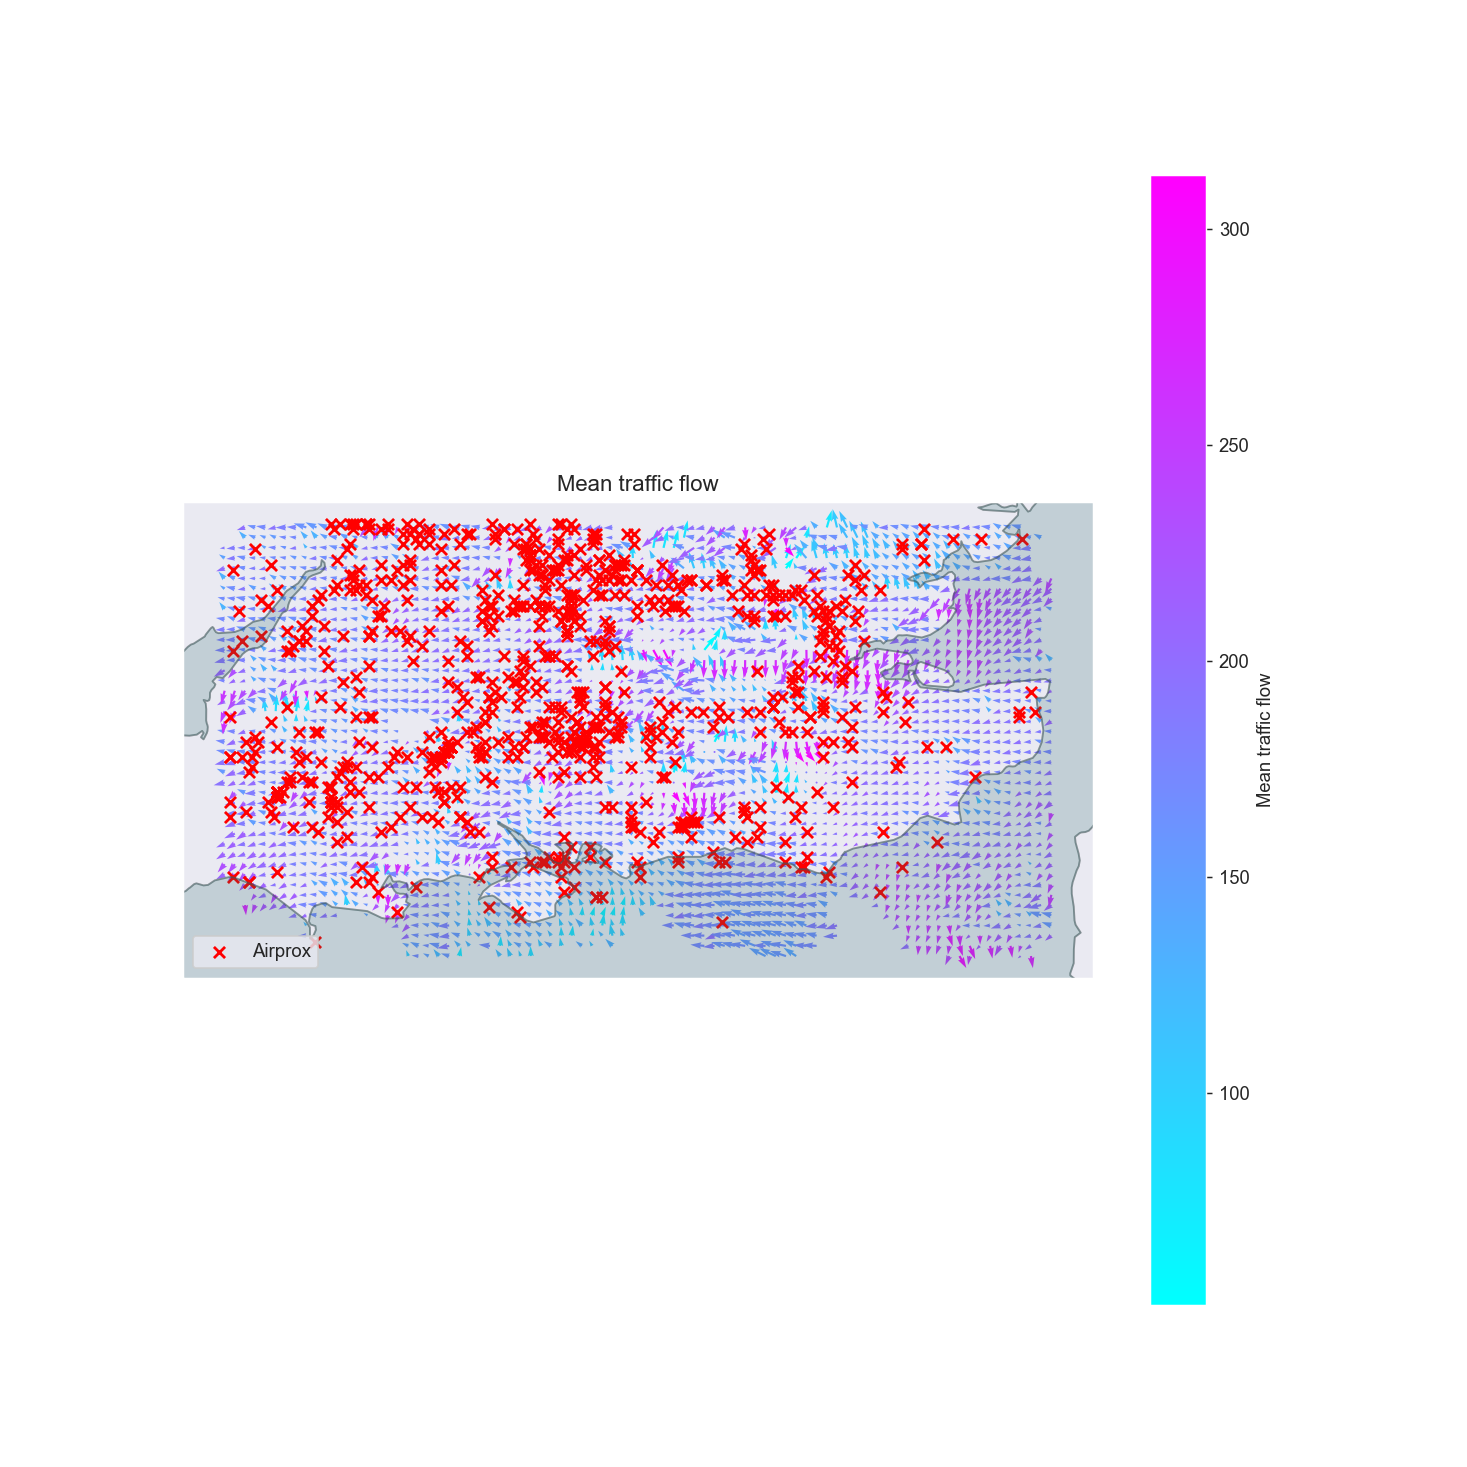

C:\Users\Aliak\AppData\Local\Temp\ipykernel_9976\695449155.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(flow)


In [103]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.quiver(tfc_mgdf['x'],
                 tfc_mgdf['y'],
                 tfc_mgdf['track_u'],
                 tfc_mgdf['track_v'],
                 tfc_mgdf['track_mean'],
                 scale_units=None,
                 cmap='cool')

aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean traffic flow')
cb = fig.colorbar(flow)
cb.set_label('Mean traffic flow')
ax.legend([aps], ['Airprox'])

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

<IPython.core.display.Javascript object>


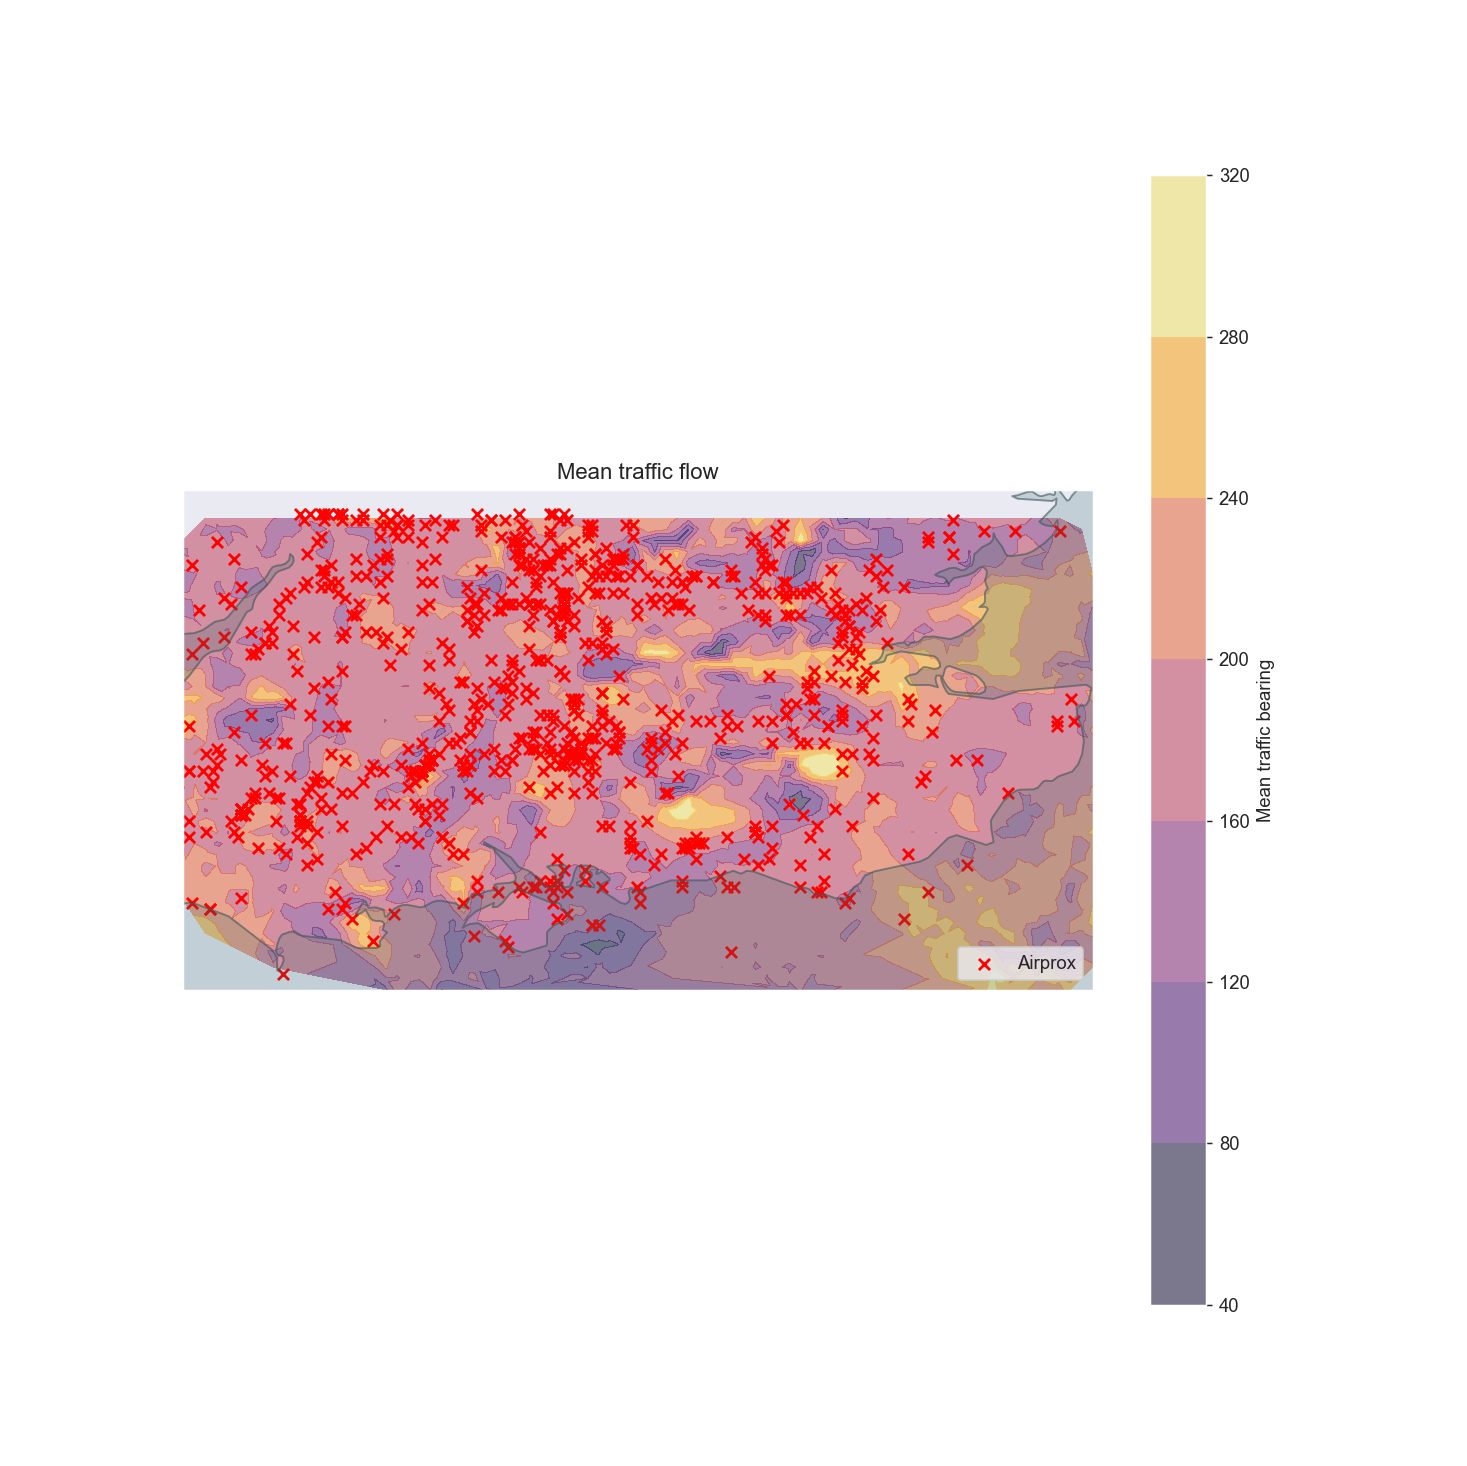

C:\Users\Aliak\AppData\Local\Temp\ipykernel_9976\2139612070.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(flow)


In [104]:
from cartopy.crs import Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(tfc_mgdf['x'],
                      tfc_mgdf['y'],
                      # tfc_gdf['track_u'],
                      # tfc_gdf['track_v'],
                      tfc_mgdf['track_mean'],
                      alpha=0.5,
                      cmap='inferno')

aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean traffic flow')
cb = fig.colorbar(flow)
cb.set_label('Mean traffic bearing')
ax.legend([aps], ['Airprox'])

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

In [ ]:
fig, ax = plt.subplots(
    1, 1, figsize=(11, 11), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

flow = ax.tricontourf(
    tfc_mgdf['x'],
    tfc_mgdf['y'],
    tfc_mgdf['altitude_mean'],
    alpha=0.5,
    cmap='inferno')

# aps = ax.scatter(airprox_gdf['x'], airprox_gdf['y'], c='r', marker='x')

ax.set_title('Mean altitude')
cb = fig.colorbar(flow)
cb.set_label('Mean altitude')
# ax.legend([aps], ['Airprox'])

## Testing hypotheses
All tests are done to 5% significance unless otherwise specified.

In [105]:
from scipy import stats as ss

sig_lvl = 0.05

### Track correlation
First, the correlation of direction variance with airprox location is tested. The mean standard deviation for directions in the entire area is found and compared to that of just where airproxes occurred:

In [106]:
print('Overall mean of stddev: ', non_airprox_tfc['track_std'].mean(), ' for ', len(non_airprox_tfc['track_std']),
      ' samples')
print('Airprox location mean of stddev: ', airproxes_with_tfc['track_std'].mean(), 'for ',
      len(airproxes_with_tfc['track_std']), ' samples')

Overall mean of stddev:  91.58161407822448  for  2704  samples
Airprox location mean of stddev:  97.53920687429677 for  834  samples


In [107]:
F, p = ss.bartlett(non_airprox_tfc['track_std'], airproxes_with_tfc['track_std'])
print(f'Bartlett equal variance test gives score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

Bartlett equal variance test gives score of 140.7469982738948 at a p-significance of 1.8275340734181224e-32
The hypothesis is accepted (F=140.7469982738948, p=1.8275340734181224e-32)


### Density Correlation

The count of unique flights within a cell is used as a measure of traffic density.

Otherwise the same procedure as above

In [108]:
print('Overall mean: ', non_airprox_tfc['flight_id_nunique'].mean(), ' for ', len(non_airprox_tfc['flight_id_nunique']),
      ' samples')
print('Airprox location mean: ', airproxes_with_tfc['flight_id_nunique'].mean(), 'for ',
      len(airproxes_with_tfc['flight_id_nunique']), ' samples')

Overall mean:  2824.033284023669  for  2704  samples
Airprox location mean:  1447.5983213429256 for  834  samples


In [109]:
F, p = ss.f_oneway(non_airprox_tfc['flight_id_nunique'], airproxes_with_tfc['flight_id_nunique'])
print(f'One-Way ANOVA test gives F-score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

One-Way ANOVA test gives F-score of 9.577010365813738 at a p-significance of 0.001985694888919344
The hypothesis is accepted (F=9.577010365813738, p=0.001985694888919344)


### Speed correlation

First the difference in the overall traffic flow speed is compared between airprox and non-airprox traffic

In [110]:
print('Overall mean: ', np.array(non_airprox_tfc['groundspeed_mean']).mean(), ' for ', len(non_airprox_tfc['groundspeed_mean']),
      ' samples')
print('Airprox location mean: ', np.array(airproxes_with_tfc['groundspeed_mean']).mean(), 'for ',
      len(airproxes_with_tfc['groundspeed_mean']), ' samples')

Overall mean:  170.1  for  2704  samples
Airprox location mean:  143.8 for  834  samples


In [111]:
F, p = ss.f_oneway(non_airprox_tfc['groundspeed_mean'], airproxes_with_tfc['groundspeed_mean'])
print(f'One-Way ANOVA test gives F-score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

One-Way ANOVA test gives F-score of 199.04337450007546 at a p-significance of 5.165757016233214e-44
The hypothesis is accepted (F=199.04337450007546, p=5.165757016233214e-44)


Now the difference in *spread* of traffic flow speeds is compared between airprox and non-airprox traffic

In [112]:
print('Overall mean of stddev: ', np.array(non_airprox_tfc['groundspeed_std']).mean(), ' for ', len(non_airprox_tfc['groundspeed_std']),
      ' samples')
print('Airprox location mean of stddev: ', np.array(airproxes_with_tfc['groundspeed_std']).mean(), 'for ',
      len(airproxes_with_tfc['groundspeed_std']), ' samples')

Overall mean of stddev:  79.87529854410622  for  2704  samples
Airprox location mean of stddev:  69.79658752495767 for  834  samples


In [94]:
F, p = ss.bartlett(non_airprox_tfc['groundspeed_std'], airproxes_with_tfc['groundspeed_std'])
print(f'Bartlett equal variance test gives score of {F} at a p-significance of {p}')
if p <= sig_lvl:
    print(f'The hypothesis is accepted (F={F}, p={p})')
else:
    print('Null hypothesis is accepted.')

Bartlett equal variance test gives score of 4.801101934654067 at a p-significance of 0.0284415401601552
The hypothesis is accepted (F=4.801101934654067, p=0.0284415401601552)
